<span style="color:red; font-size:30px;"> The aim of this short code is to demonstrate that in the limit of very large size of a neural network the output distribution of data is Gaussian.</span>

We use a very simple forward NN with a single hidden layer.

If we use as input gaussian distributions with Mu=0 and STD=1 and we define the STD of the output layer as STD/hidden_size, then the minimum number of necessary neurons to have a final gaussian distribution is 3 (hidden_size = 3).

Via continuous time gradient descent, the evolution of the parameters $\theta$ and the logits $f$ can be written as

$\dot{\theta}_t  = -\eta \nabla_\theta f_t(\mathcal{X})^T \nabla_{f_t(\mathcal{X})}\mathcal{L}$,

$\dot{f}_t(\mathcal{X}) = \nabla_\theta f_t(\mathcal{X})\dot{\theta}_t = -\eta \hat{\Theta}_t(\mathcal{X},\mathcal{X}) \nabla_{f_t(\mathcal{X})}\mathcal{L}$.

Here, the quantity $\nabla_\theta f_t(\mathcal{X})$ is the gradient of the output of the NN in the space of the parameters. This quantity will have indices in the spaces of the parameters, of the number of inputs and possibly in the space of the repetitions of the initialization of the parameters from the gaussian distribution. 

$ \bigg[ \nabla_{[\theta^\ell]_{i_{init}}} f_t(\mathcal{X_{n}}) \bigg] = \bigg[ \nabla_\theta f_t(\mathcal{X}) \bigg]_{\ell, n}^{i_{init}}$ where  $i_{init} = 1, ..., N_{boot}$,  $\ell = 1, ...,   L_{pars}$, $n = 1, ..., N_{in}$.

Indeed the index $n$ goes on number of data, the index $\ell$ goes on the number of parameters and $i_{init}$ goes on the different initializations of the parameters.

### Notes

We add the parameter $\sigma_b$ for the bias and $\sigma_w$ for the weights in the definition of the forward function associated with the Neural Network. 

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import normaltest
from scipy.stats import norm
from scipy.optimize import curve_fit
import math
import sys

2023-07-23 19:41:38.959295: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-23 19:41:39.998339: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-23 19:41:40.005624: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-23 19:41:46.379068: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


=======================================================================================


<span style="color:blue; font-size:30px;"> Functions Definition </span>


$\bullet$ <span style="color:black; font-size:15px;"> $\textit{inizialization}$ </span> : it builds the initialization of the weights and the biases of the NN. The inputs for the function are the size of the input of the NN, the size of the hidden layer, i.e. the number of neurons (we are considering that all the hidden layers have the same number of neurons), the mean and the sigma of the Gaussian distribution from which we extract the values and finally the number of layers;

$\bullet$ <span style="color:black; font-size:15px;"> $\textit{forward}$ </span> : it defines the architecture of the NN and it computes the gradients of the output of the NN with respect the parameters of the weights and the biases;

$\bullet$ <span style="color:black; font-size:15px;"> $\textit{bootobj_extr}$ </span> : it extracts from the list a one parameter to plot the input histogram on the bootstrap events;


$\bullet$ <span style="color:black; font-size:15px;"> $\textit{data_law}$ </span> : it defines the law that we want to reconstruct;


$\bullet$ <span style="color:black; font-size:15px;"> $\textit{mean}$ </span> : it performs the bootstrap mean;


$\bullet$ <span style="color:black; font-size:15px;"> $\textit{std_dev}$ </span> : it performs the bootstrap std.


=======================================================================================

In [3]:
# Initialization of weights and bias with a normal distribution
def initialization(input_size_, hidden_size_, Mu_, STD_, nl):
    bname = 'b{}'.format(nl)
    Wname = 'W{}'.format(nl)
    WR = tf.Variable(tf.random.normal([input_size_, hidden_size_], mean=Mu_, stddev=STD_), name=Wname)
    BR = tf.Variable(tf.random.normal([hidden_size_], mean=Mu_, stddev=STD_), name=bname)
    return WR,BR

# Define the forward function to compute the output of the neural network
def forward(X, i, activation, depth_):
    with tf.GradientTape() as tape:
        tape.watch([param for param in [Ws[i, j] for j in range(depth_)] + [Bs[i, j] for j in range(depth_)]])
        
        A = X
        for j in range(depth_):
            Z = tf.add(tf.matmul(A, sigma_w/lsizes[j]**0.5*Ws[i, j]), sigma_b*Bs[i, j])
            A = activation(Z)
            
        Z_last = Z
    
        gradients = tape.gradient(Z_last, [Ws[i, j] for j in range(depth_)] + [Bs[i, j] for j in range(depth_)])
    return Z_last, gradients


def bootobj_extr(layer_, el1_, el2_):
    A = np.zeros(Nboot)
    B = np.zeros(Nboot)
    for i in range(Nboot):
        matrW = Ws[i, layer_]
        A[i] = matrW[el1_, el2_]
        vecB = Bs[i,layer_]
        B[i] = vecB[el1_]
    return A,B

#Chosen law for the test of the NN
def data_law(x_):
    return np.sin(np.squeeze(x_))

#Bootstrap Mean and Sigma
def mean(arr):
    return sum(arr)/len(arr)
def std_dev(arr):
    arr_mean = mean(arr)
    return (sum([(i - arr_mean)**2 for i in arr]) / (len(arr)-1))**0.5

=======================================================================================


<span style="color:blue; font-size:30px;"> NN output computation </span>

In this part of the code we define the dimension of the NN and the input parameters.Then, given a training input and a test input we compute the output of the NN at the initialization. We also extract the gradient in both cases. These gradients are necessary to compute the $\Theta$s later in the code.

If we call:

$\bullet N_0$: the input size;

$\bullet N_\ell$ with $\ell \in [1,L]$: the number of neurons for the $\ell$ hidden layer;

$\bullet N_{L+1}$: the number of output neurons;

the number of parameters of the NN will be

$N_{tot} = (N_0\times N_1 + N_1) + (N_1\times N_2 + N_2) + (N_2\times N_3 + N_3) + ... + (N_{L}\times N_{L+1} + N_{L+1}) =\sum_{i=1}^{L+1} (N_{i-1}\times N_{i} + N_{i})$


where the $L+1$ layer is the output layer.

If we have a NN with a monodimensional input $N_0=1$ and a monodimensional output $N_{L+1}=1$ and 3 hidden layers having 3 neurons each, $N_\ell = 3$ for $\ell \in [1,L]$, then the number of parameters will be

$N_{tot} = (1\times 3 + 3) + (3\times 3 + 3)\times 2 + (3\times 1 + 1) = 34$.

Of course the gradient will be a vector of that dimension. If we have $S$ inputs the it will become a matrix $S \times N_{tot}$.

=======================================================================================

In [4]:
# Define the dimensions of the NN
input_size = 1
hidden_size = 3
output_size = 1
depth = 4 #the depth also contains the output layer
Nboot = 100

lsizes = np.concatenate(([input_size], np.repeat(hidden_size, depth-1), [output_size]))
print('The structure of the NN is: ',lsizes)

Lpar = input_size*hidden_size + (depth-2)*hidden_size**2 + (depth-1)*hidden_size + hidden_size*output_size + output_size

print('The number of parameters is: ',Lpar)
print('The number of initializations is: ',Nboot)

# Define the net parameters
sigma_b = 1.
sigma_w = 1.

#Define parameters of the Gaussian distribution
STD = 0.08
Mu = 0.5


#Weights and biases generation
Ws = np.empty((Nboot, depth), dtype=object)  
Bs = np.empty((Nboot, depth), dtype=object)
for i in range(Nboot):
    for l in range(depth):
        Ws[i, l], Bs[i, l] = initialization(lsizes[l], lsizes[l+1], Mu, STD, l)
    
# Input quantities
Nin = 2
X = tf.random.uniform(shape=(Nin,1,1), minval=1, maxval=200, dtype=tf.float32)
xtest = tf.random.uniform(shape=(Nin,1,1), minval=1, maxval=200, dtype=tf.float32)
    
print('The number of input quantities is: ', Nin)
    
# We compute the output for each event for an input
output_array = []
output_array_test = []
grads_array = np.array([])
grads_array_test = np.array([])    
for k in range(Nin):
    for i in range (0, Nboot):
        
        Y, Grad = forward(X[k],i,tf.nn.relu, depth)
        Y_test, Grad_test = forward(xtest[k],i,tf.nn.relu, depth)
        output_array.append(Y.numpy()[0][0])
        output_array_test.append(Y_test.numpy()[0][0])
        
        # Flattening e concatenation of derivatives for training and test
        grads_np = np.concatenate([g.numpy().flatten() for g in Grad])  
        grads_test_np = np.concatenate([g.numpy().flatten() for g in Grad_test])  
        grads_array = np.vstack([grads_array, grads_np]) if grads_array.size else grads_np
        grads_array_test = np.vstack([grads_array_test, grads_test_np]) if grads_array_test.size else grads_test_np 


output_array = np.array(output_array).reshape((Nin,Nboot))
output_array_test =  np.array(output_array_test).reshape((Nin,Nboot))
grads_array = grads_array.reshape((Nin,Nboot,int(grads_array[0,:].shape[0]))) 
grads_array_test = grads_array_test.reshape((Nin,Nboot,int(grads_array_test[0,:].shape[0]))) 

print('The dimensions of the training and test data matrix are respectively (Nin, Nboot): ', output_array.shape, output_array.shape)
print('The dimensions of the training gradient and test are respectively (Nin, Nboot, Lpar): ', grads_array.shape, grads_array_test.shape)

The structure of the NN is:  [1 3 3 3 1]
The number of parameters is:  34
The number of initializations is:  100
The number of input quantities is:  2
The dimensions of the training and test data matrix are respectively (Nin, Nboot):  (2, 100) (2, 100)
The dimensions of the training gradient and test are respectively (Nin, Nboot, Lpar):  (2, 100, 34) (2, 100, 34)


=======================================================================================


<span style="color:blue; font-size:30px;"> Input distributions histograms</span>


We check the input distribution of weights and biases.

=======================================================================================


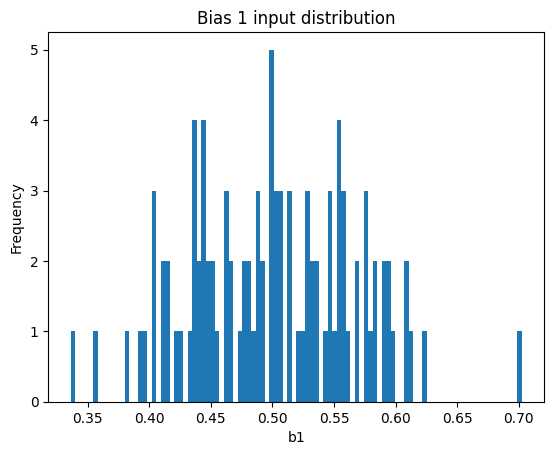

Data follow a gaussian distribution.


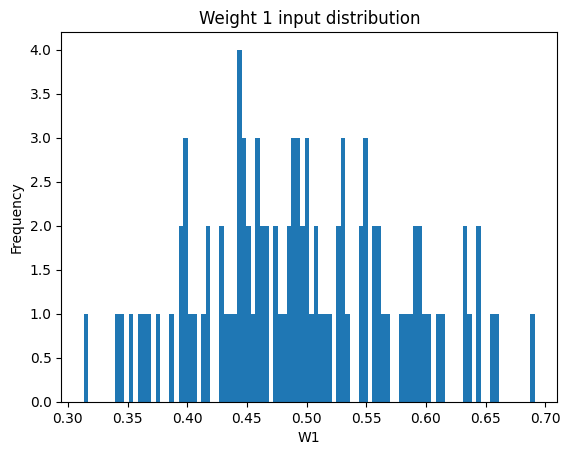

<Figure size 640x480 with 0 Axes>

In [5]:
Whist, Bhist = bootobj_extr(1,1,1)


# Print the input distributions of the weights and bias
plt.hist(Bhist, bins=100)
plt.xlabel('b1')
plt.ylabel('Frequency')
plt.title('Bias 1 input distribution')
plt.savefig('Bias1.png')
plt.show()

# Test of the gaussianity
stat, p = normaltest(Bhist)

# Print the result of the test
if p < 0.05:
    print("Data don't follow a gaussian distribution.")
else:
    print("Data follow a gaussian distribution.")

plt.clf()


plt.hist(Whist, bins=100)
plt.xlabel('W1')
plt.ylabel('Frequency')
plt.title('Weight 1 input distribution')
plt.show()

plt.clf()

=======================================================================================


<span style="color:blue; font-size:30px;"> Output distribution histogram</span>


We study the output distribution.


=======================================================================================

Gaussian distribution.


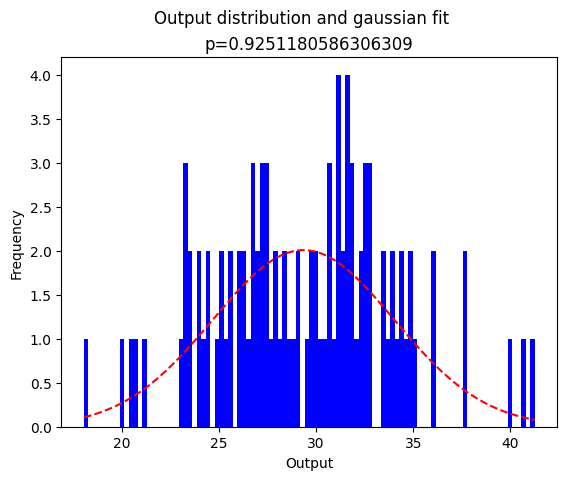

Mean: 29.349733934447027
Standard deviation: -4.665165155062336
Amplitude: 2.0067443106847085


In [6]:
# Test of the gaussianity
stat, p = normaltest(output_array[0])

# Print the result of the test
if p < 0.05:
    string = "No gaussian distribution." 
    print(string)
else:
    string = "Gaussian distribution."
    print(string)

# Take parameters of our histogram
counts, bins, _ = plt.hist(output_array[0], bins=100)

ylim = max(counts)-10
xlim = min(bins)
xlim2 = max(bins)

# Define the Gaussian function
def gaussian(x, mu, sigma, A):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))


# Plot the histogram and the fitted Gaussian function
plt.clf()
x = np.linspace(xlim, xlim2, 1000)
plt.hist(output_array[0], bins=100, color ='blue')
plt.xlabel('Output')
plt.ylabel('Frequency')
plt.suptitle('Output distribution and gaussian fit')
plt.title('p='+ str(p))
p0 = [(xlim+xlim2)/2, xlim2-xlim, 1]
coeff, var_matrix = curve_fit(gaussian, bins[:-1], counts, p0=p0)
plt.plot(x, gaussian(x, *coeff), 'r--', label='fit')    
    
#plt.text(xlim-3, ylim, 'L='+ str(hidden_size), fontsize=18)
#plt.text(xlim-3, ylim, string, fontsize=8)
plt.savefig('Output.png')
plt.show()

# Print gaussian parameters
print("Mean:", coeff[0])
print("Standard deviation:", coeff[1])
print("Amplitude:", coeff[2])

=======================================================================================

<span style="color:blue; font-size:30px;"> Computation of the theta quantities </span>


$\hat{\Theta}_0(\mathcal{X},\mathcal{X}) = \theta = \sum_{l=1}^{L+1}\nabla_{\theta^\ell}f_0(\mathcal{X})\nabla_{\theta^\ell}f_0(\mathcal{X})^T$

$\hat{\Theta}_0(x,\mathcal{X}) = \theta_{test} = \sum_{l=1}^{L+1}\nabla_{\theta^\ell}f_0($x$)\nabla_{\theta^\ell}f_0(\mathcal{X})^T$ 

where $x$ is the test input value while $\mathcal{X}$ is the training input value.

The theta quantities are scalars in the space of the parameters $\theta$ and matrices in the space of the input/output, namely 

$\big[ \Theta_0 \big]_{n_1, n_2}^{i_{init}} = \sum_{\ell = 1}^{L_{par}} \bigg[ \nabla_\theta f_0(\mathcal{X}) \bigg]_{\ell, n_1}^{i_{init}} \bigg[ \nabla_\theta f_0(\mathcal{X}) \bigg]_{n_2, \ell}^{i_{init}} = \begin{bmatrix}
    \Theta(\mathcal{X}_1, \mathcal{X}_1) & \Theta(\mathcal{X}_1, \mathcal{X}_2) & ... & \Theta(\mathcal{X}_{N_{in}}, \mathcal{X}_{N_in})) \\
    ...  & ... &  ... & ... \\
    \Theta(\mathcal{X}_{N_{in}}, \mathcal{X}_1) & \Theta(\mathcal{X}_{N_{in}}, \mathcal{X}_2) & ... & \Theta(\mathcal{X}_{N_{in}}, \mathcal{X}_{N_{in}}) \\
\end{bmatrix}$, 

such that in the limit of large width this becomes the covariance matrix $K_{n_1,n_2}^{i_{boot}}$.

=======================================================================================

In [7]:
#Theta computation
theta = np.zeros((Nin, Nin, Nboot))
for n1 in range(Nin):
    for n2 in range(Nin):
        for iboot in range(Nboot):
            theta[n1,n2,iboot] = sum(grads_array[n1,iboot,i]*grads_array[n2,iboot,i] for i in range(int(grads_array[0,0,:].shape[0])))

#Theta test computation
theta_test = np.zeros((Nin, Nin, Nboot))
for n1 in range(Nin):
    for n2 in range(Nin):
        for iboot in range(Nboot):
            theta_test[n1,n2,iboot] = sum(grads_array_test[n1,iboot,i]*grads_array[n2,iboot,i] for i in range(int(grads_array[0,0,:].shape[0])))

print('The shape of the theta quantities is (Nin, Nin, Nboot): ',theta.shape, theta_test.shape)

The shape of the theta quantities is (Nin, Nin, Nboot):  (2, 2, 100) (2, 2, 100)


=======================================================================================

<span style="color:blue; font-size:30px;"> Definition of the ODE solutions for the training and the test </span>

TRAINING:

$\omega_t = -\nabla_\theta f_0(\mathcal{X})^T\hat{\Theta}_0^{-1}\bigg(\mathbb{I}-e^{-\eta \hat{\Theta}_0 t}\bigg)\big(f_0(\mathcal{X})-\mathcal(Y)\big),\\$
$f_t^{lin}(\mathcal{X}) = \bigg(\mathbb{I} - e^{-\eta \hat{\Theta}_0 t}\bigg)\mathcal{Y}+e^{-\eta \hat{\Theta}_0 t} f_0(\mathcal{X}).$

TEST:

$f_t^{lin}(x) = \mu_t(x) + \gamma_t(x)$

where

$\mu_t(x) = \hat{\Theta}_0(x,\mathcal{X}) \hat{\Theta}_0^{-1} \bigg(\mathbb{I}-e^{-\eta \hat{\Theta}_0 t}\bigg) \mathcal{Y},\\$
$\gamma_t(x) = f_0(x) - \hat{\Theta}_0(x,\mathcal{X}) \hat{\Theta}_0^{-1} \bigg(\mathbb{I}-e^{-\eta \hat{\Theta}_0 t}\bigg) f_0(\mathcal{X})$


=======================================================================================

In [8]:
def Train(grad_, theta_, eta_, t_, output_, Y_):
    omega_t = -np.transpose(grad_)@(theta_**(-1))@(np.eye(len(Y_))-np.exp(-eta_*theta_*t_))*(output_ - Y_)
    f_lin = (np.eye(len(Y_))-np.exp(-eta_*theta_*t_))@Y_ + np.exp(-eta_*theta_*t_)@output_
    return omega_t, f_lin

def Ver(theta_, theta_test_, eta_, t_, Y_, output_test_, output_):
    mu_t = theta_test_@theta_**(-1)@(np.eye(len(Y_))-np.exp(-eta_*theta_*t_))@Y_
    gamma_t = output_test_ - theta_@theta_**(-1)@(np.eye(len(Y_))-np.exp(-theta_*eta_*t_))@output_
    flin_f = mu_t + gamma_t
    return flin_f
print(output_array.shape, output_array_test.shape)

(2, 100) (2, 100)


=======================================================================================

<span style="color:blue; font-size:30px;"> Computation of the training functions as a function of time $t$ for different bins </span>

We expect that in the limit of large values of time the function tends to the value $\mathcal{Y}$

=======================================================================================

[-0.96436787 -0.1253354 ] (2, 100, 34)
(2, 100) 2
(2, 34) (34, 2) (2, 100) (2,)
(100, 250, 2)


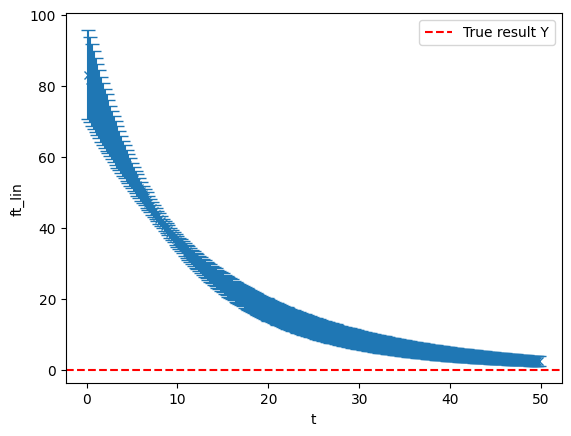

In [9]:
# True value for our chosen law
Y = np.zeros(Nin)
for i in range(Nin):
    Y[i] = data_law(X[i])
print(Y, grads_array.shape)
print(theta[:,0].shape, len(Y))

# Bins of t
Bins = np.arange(0,50,0.2)


# Computation of flin for the training
flin_tr = np.empty((Nboot, len(Bins), Nin))


print(grads_array[:,0,:].shape, np.transpose(grads_array[:,0,:]).shape, theta[:,0].shape, output_array[:,0].shape)
np.transpose(grads_array[:,0,:])@theta[:,0]**(-1)


for i in range(Nboot):
    for j in range(len(Bins)):
        _, flin_tr[i,j,:] = Train(grads_array[:,i,:],theta[:,:,i], 0.00001, Bins[j], output_array[:,i], Y)
        
        
        #flin_tr[i,j] = flin_tr_app
print(flin_tr.shape)

# Bootstrap mean and sigma
flin_tr_mu = np.empty((len(Bins), Nin))
flin_tr_s = np.empty((len(Bins), Nin))

for j in range(Nin):
    for i in range(len(Bins)):
        flin_tr_mu[i,j] = mean(flin_tr[:,i,j])
        flin_tr_s[i,j] = std_dev(flin_tr[:,i,j])
    
#print(flin_tr_mu , flin_tr_mu.shape, flin_tr_s.shape)


# Plot of the shape as a function of t
plt.errorbar(Bins[1:], flin_tr_mu[1:,1], yerr=flin_tr_s[1:,1], fmt='x', capsize=5)
plt.axhline(y=Y[1], color='r', linestyle='--', label='True result Y')
plt.legend()
plt.xlabel('t')
plt.ylabel('ft_lin')
plt.show()

=======================================================================================

<span style="color:blue; font-size:30px;"> Computation of the test functions as a function of time $t$ for different bins </span>


=======================================================================================

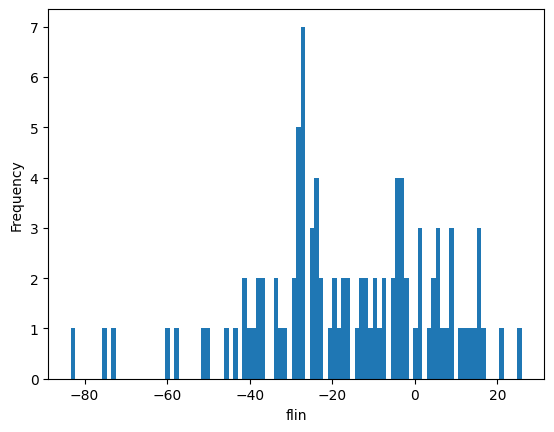

[-0.96436787 -0.1253354 ] [20.635426 27.722387 25.143127 23.140568 26.833677 28.173569 34.287792
 27.372375 28.400629 32.71597  26.651571 26.187284 41.249607 31.64432
 31.7859   31.34714  32.82256  30.29967  30.598492 29.123959 33.572315
 25.2138   27.283085 27.92856  18.047638 23.188784 34.62218  27.523136
 31.7669   28.844374 34.034245 30.450518 37.724026 25.649687 31.169975
 24.166689 24.47269  33.38887  21.24759  28.502243 35.984715 26.401186
 32.209545 33.61111  32.007454 29.743458 36.11947  40.615784 29.616077
 31.045654 23.488531 23.491032 28.418291 25.48653  31.85745  27.815582
 31.450363 24.078577 34.504204 26.95395  27.270208 27.21491  27.09168
 34.90528  29.08743  30.622772 33.93259  34.446323 26.045204 29.795994
 31.635683 31.50911  20.042473 31.616781 32.50438  35.071934 31.22396
 23.37416  30.05742  32.756195 26.122938 32.32272  30.589306 32.46684
 24.360558 37.61011  30.017324 25.381882 26.667202 31.15925  26.255236
 31.035799 23.960726 20.542805 23.276896 27.37829  24.9

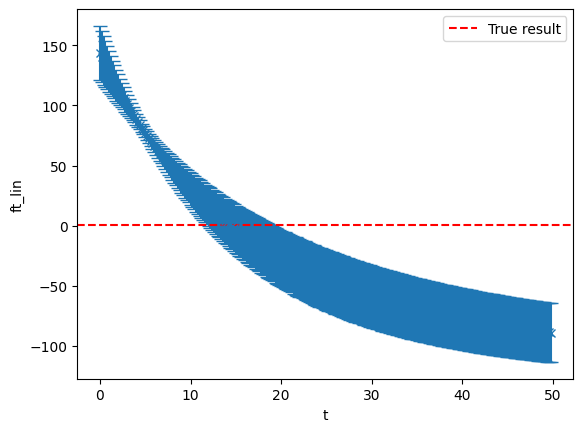

In [10]:
flin = np.empty((Nboot, len(Bins), Nin))
for i in range(Nboot):
    for j in range(len(Bins)):
        flin[i,j,:] = Ver(theta[:,:,i], theta_test[:,:,i], 0.00001, Bins[j], Y, output_array_test[:,i], output_array[:,i])
        

#print(theta_test[0]/theta[0], theta_test[0], theta[0])
        
plt.hist(flin[:,88,0], bins=100)
plt.xlabel('flin')
plt.ylabel('Frequency')
plt.title('')
plt.show()

print(Y, output_array[0])

flin_mu = np.empty((len(Bins), Nin))
flin_s = np.empty((len(Bins), Nin))
for i in range(len(Bins)):
    for j in range(Nin):
        flin_mu[i,j] = mean(flin[:,i,j])
        flin_s[i,j] = std_dev(flin[:,i,j])

print(xtest)
Y2 = data_law(xtest.numpy())

plt.errorbar(Bins, flin_mu[:,0], yerr=flin_s[:,0], fmt='x', capsize=5)
plt.axhline(Y2[0], color='r', linestyle='--', label='True result')
plt.legend()
plt.xlabel('t')
plt.ylabel('ft_lin')
plt.show()

### Experiment

Construct a neural network which simulates the interpolate function $x(\alpha) = \alpha x^{(1)} + (1-\alpha) x^{(2)}$; then, we average the results under 100 NNs

In [11]:
from tqdm import tqdm
Nin = 100
Nout = 100

xx1 = tf.constant(-1., shape=(Nin, 1, 1), dtype=tf.float32)
xx2 = tf.constant(1., shape=(Nin, 1, 1), dtype=tf.float32)

def interp(_alpha):
    condition1 = tf.logical_and(_alpha <= 1, _alpha >= 0)
    condition2 = _alpha > 1
    condition3 = _alpha < 0
    
    result = tf.where(condition1, _alpha * xx1 + (1 - _alpha) * xx2, tf.where(condition2, xx1, xx2))
    return result

alpha_out = tf.random.uniform(shape=(Nout,1,1), minval=-2, maxval=3, dtype=tf.float32)

#print(x_train)
#sys.exit()

sigma_w = np.sqrt(1.5)
sigma_b = 1.
Mu = 0.
STD = 1.
Nboot = 10
depth = 3
input_size = 1
hidden_size = 32
output_size = 1
eta = 0.5


# Numb of train epochs
num_epochs = 1000

lsizes = np.concatenate(([input_size], np.repeat(hidden_size, depth-1), [output_size]))
#print(lsizes)

#loss_fun = tf.losses.mean_squared_error()

# obser_sum = [mean output net, dev_std output net, loss]
obser_sum = np.ndarray(shape=(num_epochs, 3, Nout, Nboot), dtype=float, buffer=np.zeros((num_epochs, 3, Nout, Nboot)))

for i in tqdm(range(Nboot), desc="Progress", ncols=100):
    
    alpha_train = tf.random.uniform(shape=(Nin,1,1), minval=-2, maxval=3, dtype=tf.float32)
    #alpha_train = tf.constant([[[0]], [[1]]], shape=(2, 1, 1), dtype=tf.float32)
    x_train = interp(alpha_train)
    
    for l in range(depth):
        Ws[i, l], Bs[i, l] = initialization(lsizes[l], lsizes[l+1], Mu, STD / lsizes[l]**0.5, l)
        #print(l, Ws[i,l].shape)

    # Optimizer definition 
    optimizer = tf.keras.optimizers.Adam()

    # Train function
    @tf.function
    def train_step(X, Y):
        with tf.GradientTape() as tape:
            Z, gradients = forward(X, i, tf.nn.tanh, depth)
            loss = tf.losses.mean_squared_error(Z, x_train)  # Define loss func using Z and x_train

        variables = [param for param in [Ws[i, j] for j in range(depth)] + [Bs[i, j] for j in range(depth)]]
        gradients = tape.gradient(loss, variables)
        #eta_tf = tf.fill(tf.shape(gradients), eta)
        gradients2 = [gradients[i]*eta for i in range(len(gradients))] 
        #gradients_yy = tf.multiply(eta, gradients)
        optimizer.apply_gradients(zip(gradients2, variables))

        return Z, loss

    # Train cycle
    for epoch in range(num_epochs):
        Z, loss = train_step(alpha_train, x_train)
        loss_value = tf.reduce_mean(loss)
        
        Z, _ = forward(alpha_out, i, tf.nn.tanh, depth)
        Z2 = tf.square(Z)
        #print(Z.numpy())
        obser_sum[epoch, 0, :, i] = np.reshape(Z.numpy(), (Nout,) )
        obser_sum[epoch, 1, :, i] = np.reshape(Z2.numpy(), (Nout,) )
        #obser_sum[epoch, 2, :, i] = np.reshape(loss.numpy(), (Nout,) )
alpha_np = alpha_train.numpy()

Progress: 100%|█████████████████████████████████████████████████████| 10/10 [01:09<00:00,  6.93s/it]


[0.01946186 0.02807866 0.00756523 0.00722722 0.03387585 0.00760792
 0.01809768 0.01273282 0.03660697 0.01508766 0.01560521 0.01390558
 0.00648764 0.01384649 0.01503779 0.01601887 0.00660368 0.01354823
 0.00976211 0.01044777 0.00562528 0.00540511 0.01211363 0.00571628
 0.00876877 0.00859984 0.01621672 0.00563077 0.00588424 0.00718251
 0.00622392 0.02280934 0.03663487 0.01204366 0.01057805 0.0102196
 0.01402227 0.00510329 0.00530144 0.00934982 0.00945264 0.0176862
 0.00977675 0.0068469  0.02193371 0.03670299 0.02687444 0.00933863
 0.00517128 0.00599823 0.01060248 0.01236169 0.01319986 0.01937712
 0.0074896  0.01316498 0.02220057 0.0070663  0.01208001 0.01157959
 0.01900775 0.0223838  0.03619677 0.02262226 0.03207342 0.01896194
 0.03595899 0.02457919 0.01454781 0.02033719 0.01397724 0.03306835
 0.01256942 0.00848243 0.01485526 0.00511115 0.01593043 0.02240144
 0.02214687 0.02059918 0.00570998 0.00738441 0.01363825 0.01338712
 0.01379698 0.00529598 0.01553353 0.01399237 0.03550048 0.022698

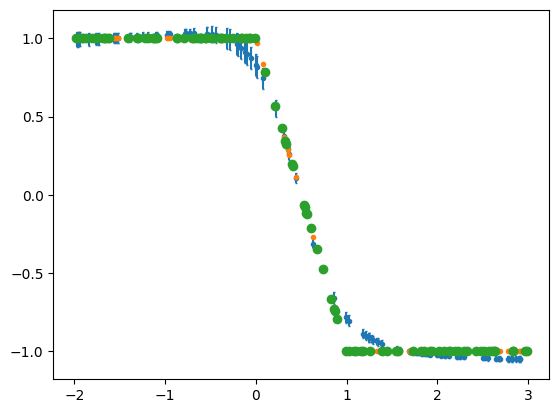

In [12]:
xx1 = tf.constant(-1., shape=(Nout, 1, 1), dtype=tf.float32)
xx2 = tf.constant(1., shape=(Nout, 1, 1), dtype=tf.float32)

alpha_np = alpha_out.numpy()
alpha_np = np.reshape(alpha_out, (Nout,))

x_np = interp(alpha_out)
x_np = np.reshape(x_np.numpy(), (Nout,))
epoch_fix = 999

y = np.array([0.]*len(alpha_np))
erry = np.array([0.]*len(alpha_np))

for i in range(len(alpha_np)):
    y[i] = mean(obser_sum[epoch_fix, 0, i, :])
    erry[i] = np.sqrt(mean(obser_sum[epoch_fix, 1, i, :]) - y[i]**2.)#std_dev(Nboot*obser_sum[epoch_fix, 0, i, :])

print(erry)

#print(mean(obser_sum[epoch_fix, 0, 0, :]), std_dev(obser_sum[epoch_fix, 0, 0, :])*Nboot**0.5, (mean(obser_sum[epoch_fix, 1, 0, :]) - mean(obser_sum[epoch_fix, 0, 0, :])**2.)**0.5)

#err = np.sqrt(obser_sum[epoch_fix, 1, :] - obser_sum[epoch_fix, 0, :]**2.)
#print(alpha_np[0:5], x_np[0:5], obser_sum[400, 0, 0:5], obser_sum[400, 2, 0:5])
plt.errorbar(alpha_np, y, yerr=2.*erry, fmt = '.', capsize=1)
plt.errorbar(alpha_np, x_np, fmt = '.', capsize=1)
plt.errorbar(np.reshape(alpha_train.numpy(), (Nin, )), np.reshape(x_train.numpy(), (Nin,)), fmt = 'o', capsize=30)
plt.show()

# PUT THE BIAS AT ZERO AND CHANGE THE DEV_STD


In [13]:
def Sigma(arr1, arr2):
    Sigma = np.ndarray(shape = (2,2))
    Sigma[0,0] = np.dot(arr1,arr1)
    Sigma[0,1] = np.dot(arr1,arr2)
    Sigma[1,0] = Sigma[0,1]
    Sigma[1,1] = np.dot(arr2,arr2)
    return Sigma

def calT(Sigma):
    #calTp = 4./ np.pi / np.sqrt(np.linalg.det(eye(2) + 2*Sigma))
    calT = 2./np.pi * np.arcsin( 2.* Sigma[0,1] / np.sqrt((1+2*Sigma[0,0])*(1+2*Sigma[1,1])))
    return calT#, calTp

def mathT(a, b, c, d):
    return 2./np.pi * np.arcsin( 2.* b / np.sqrt((1+2*a)*(1+2*d)))

def mathTp(a, b, c, d):
    det = a*c - b*d
    return 4./ np.pi / np.sqrt(np.linalg.det(eye(2) + 2*det))

The expression ${\cal K}^\ell$ indicates a set of function applied at each $\ell$ layer. Therefore, the ${\cal K}^{L+1}$ corresponds ${\cal K}$.

In [14]:
def Kappa(arr1, arr2, l_index, sigma_w, sigma_b, n0):
    if l_index == 1:
        return np.dot(arr1,arr2)/n0*sigma_w**2. + sigma_b**2.
    else:
        T11 = kappa(arr1, arr1, l_index-1, sigma_w, sigma_b, n0)
        T12 = kappa(arr1, arr2, l_index-1, sigma_w, sigma_b, n0)
        T21 = T12
        T22 = kappa(arr2, arr2, l_index-1, sigma_w, sigma_b, n0)
        return sigma_w**2.*mathT(T11, T12, T21, T22) + sigma_b**2.

    
    
def Theta(arr1, arr2, l_index, sigma_w, sigma_b, n0):
    if l_index == 1:
        return np.dot(arr1,arr2)/n0*sigma_w**2. + sigma_b**2.
    else:
        T11 = kappa(arr1, arr1, l_index-1, sigma_w, sigma_b, n0)
        T12 = kappa(arr1, arr2, l_index-1, sigma_w, sigma_b, n0)
        T21 = T12
        T22 = kappa(arr2, arr2, l_index-1, sigma_w, sigma_b, n0)
        return sigma_w**2.*mathTp(T11, T12, T21, T22)*Theta(arr1, arr2, l_index-1, sigma_w, sigma_b, n0)

### NNGP 